In [1]:

from google.colab import drive, files
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras import Model, Sequential
from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import os
random.seed(1234)

In [2]:
## Cargamos Drive e importamos las imágenes de train y test
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/Colab Notebooks/train.zip" -d "/content"
!unzip "/content/drive/MyDrive/Colab Notebooks/test.zip" -d "/content"

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/train/28_CropBroadRain_jpeg/28_CropBroadRain_100.0__187_58.1_(-12.0834185497,-46.1504087324)_BR_Tocantins_Taguatinga_Taguatinga.jpg  
  inflating: /content/train/28_CropBroadRain_jpeg/28_CropBroadRain_100.0__188_60.1_(-12.1035408121,-46.2510200442)_BR_Tocantins_Taguatinga_Taguatinga.jpg  
  inflating: /content/train/28_CropBroadRain_jpeg/28_CropBroadRain_100.0__189_60.9_(-12.1035408121,-46.1504087324)_BR_Tocantins_Taguatinga_Taguatinga.jpg  
  inflating: /content/train/28_CropBroadRain_jpeg/28_CropBroadRain_100.0__191_59.5_(-12.1236630744,-46.2107755194)_BR_Tocantins_Taguatinga_Taguatinga.jpg  
  inflating: /content/train/28_CropBroadRain_jpeg/28_CropBroadRain_100.0__192_60.5_(-12.1236630744,-46.1302864701)_BR_Tocantins_Taguatinga_Taguatinga.jpg  
  inflating: /content/train/28_CropBroadRain_jpeg/28_CropBroadRain_100.0__193_53.4_(-12.1840298614,-46.3516313561)_BR_Tocantins_Taguatinga_Taguatinga.jpg  
  i

In [3]:
## Renombramos las carpetas para que tf las lea en orden
dirnames = sorted(os.listdir("train"))
for dir in dirnames:
  newname = ""

  if (len(dir.split('_')[0]) == 1):
    newname = '0'+dir.split('_')[0]
  else:
    newname = dir.split('_')[0]

  os.rename("train/"+dir,"train/"+newname)

In [4]:
## Función que muestra la evolución de las accuracy de train y validacion
## durante el entrenamiento.
def mostrarEvolucion(hist):

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()


def predecir_guardar_test(modelo, nombre_salida, test):
    y_pred = modelo.predict(test)
    classes = np.argmax(y_pred, axis=1)
    classes = np.array(classes)
    classes = classes + 1

    d = {'id.jpg': sorted(os.listdir("test")), 'label': classes}
    df = pd.DataFrame(data=d)
    df.to_csv(nombre_salida, index=False)

In [5]:
training = tf.keras.utils.image_dataset_from_directory(
  "train",
  validation_split=0.2,
  subset="training",
  seed=1234,
  image_size=(224, 224),
  batch_size = 32)

validation = tf.keras.utils.image_dataset_from_directory(
  "train",
  validation_split=0.2,
  subset="validation",
  seed=1234,
  image_size=(224, 224),
  batch_size = 32)

test = tf.keras.utils.image_dataset_from_directory(
  "test",
  shuffle=False,
  labels=None,
  image_size=(224, 224),
  batch_size = 32)

Found 10266 files belonging to 29 classes.
Using 8213 files for training.
Found 10266 files belonging to 29 classes.
Using 2053 files for validation.
Found 1618 files belonging to 1 classes.


In [6]:
datagen = ImageDataGenerator(
                                           vertical_flip = True,
                                           validation_split = 0.2)

training_generator = datagen.flow_from_directory(
  "train",
  subset="training",
  seed=1234,
  target_size=(224, 224),
  batch_size = 32,
  class_mode='sparse')


Found 8236 images belonging to 29 classes.


In [ ]:
import tensorflow as tf 


import tensorflow_hub as hub
num_classes = 29
resnet_remote_sensing = hub.KerasLayer("https://tfhub.dev/google/remote_sensing/bigearthnet-resnet50/1",
                                   trainable=True)

num_classes = 29
IMG_HEIGHT, IMG_WIDTH = 224,224

resnet_remote_sensing.trainable = False
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(IMG_HEIGHT,IMG_WIDTH,3)),
    resnet_remote_sensing,
    BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, kernel_initializer='zeros')
])

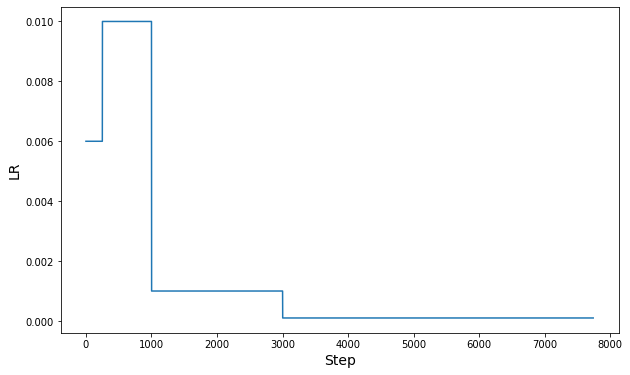

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 keras_layer_3 (KerasLayer)  (None, 2048)              23633899  
                                                                 
 batch_normalization_3 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 29)                59421     
                                                                 
Total params: 23,701,512
Trainable params: 63,517
Non-trainable params: 23,637,995
_____________________________________

In [ ]:
EPOCHS = 30

num_train_per_batch = len(training_generator)
num_val_per_batch = len(validation)

TOTAL_STEPS = int(num_train_per_batch * EPOCHS)

SCHEDULE_BOUNDARIES = [250,1000,3000]
scheduled_lrs = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,values=[0.006, 0.01, 0.001,0.0001])

lrs = [scheduled_lrs(step) for step in range(TOTAL_STEPS)]
plt.figure(figsize=(10, 6))
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

optimizer = tf.keras.optimizers.SGD(scheduled_lrs)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer,
             loss=loss_fn,
             metrics=['accuracy'])

model.build()

model.summary()

In [ ]:
callback = EarlyStopping(patience=10,restore_best_weights=True)
history = model.fit(
   training_generator,
   batch_size=32,
   epochs=30,
   callbacks=callback,
   validation_data=validation)
tf.keras.models.save_model(model, "/content/drive/MyDrive/model")

Epoch 1/30
258/258 [==============================] - 70s 261ms/step - loss: 1.2591 - accuracy: 0.6705 - val_loss: 1.1439 - val_accuracy: 0.7331
Epoch 2/30
258/258 [==============================] - 67s 261ms/step - loss: 0.7669 - accuracy: 0.7678 - val_loss: 0.7241 - val_accuracy: 0.7876
Epoch 3/30
258/258 [==============================] - 67s 261ms/step - loss: 0.6415 - accuracy: 0.8006 - val_loss: 0.6470 - val_accuracy: 0.7983
Epoch 4/30
258/258 [==============================] - 67s 260ms/step - loss: 0.5733 - accuracy: 0.8235 - val_loss: 0.5893 - val_accuracy: 0.8076
Epoch 5/30
258/258 [==============================] - 67s 261ms/step - loss: 0.5330 - accuracy: 0.8328 - val_loss: 0.5763 - val_accuracy: 0.8139
Epoch 6/30
258/258 [==============================] - 67s 261ms/step - loss: 0.5165 - accuracy: 0.8452 - val_loss: 0.5746 - val_accuracy: 0.8169
Epoch 7/30
258/258 [==============================] - 67s 261ms/step - loss: 0.5172 - accuracy: 0.8400 - val_loss: 0.5717 - val_ac

INFO:tensorflow:Assets written to: /content/drive/MyDrive/model/assets


In [ ]:
export_module_dir = '/content/drive/myDrive/'
!mkdir /content/model_ft_freeze
model.save('/content/model_ft_freeze')

INFO:tensorflow:Assets written to: /content/model_ft_freeze/assets


INFO:tensorflow:Assets written to: /content/model_ft_freeze/assets


NotImplementedError: ignored

In [ ]:
model.layers[1].trainable = False


INFO:tensorflow:Assets written to: /content/model/assets


INFO:tensorflow:Assets written to: /content/model/assets


In [13]:
model_trained = tf.keras.models.load_model("/content/drive/MyDrive/model")
model_trained.layers[1].trainable = True
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt_fine = Adam(learning_rate=1e-5)
model_trained.compile(optimizer=opt_fine,
             loss=loss_fn,
             metrics=['accuracy'])

model_trained.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 keras_layer_3 (KerasLayer)  (None, 2048)              23633899  
                                                                 
 batch_normalization_3 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 29)                59421     
                                                                 
Total params: 23,701,512
Trainable params: 23,651,976
Non-trainable params: 49,536
_____________________________________

In [14]:
callback = EarlyStopping(patience=3,restore_best_weights=True)
history = model_trained.fit(
   training,
   batch_size=32,
   epochs=70,
   callbacks=callback,
   validation_data=validation)

Epoch 1/70
257/257 [==============================] - 215s 808ms/step - loss: 0.5206 - accuracy: 0.8349 - val_loss: 0.4626 - val_accuracy: 0.8441
Epoch 2/70
257/257 [==============================] - 207s 806ms/step - loss: 0.4153 - accuracy: 0.8708 - val_loss: 0.4340 - val_accuracy: 0.8534
Epoch 3/70
257/257 [==============================] - 207s 805ms/step - loss: 0.3473 - accuracy: 0.8971 - val_loss: 0.4139 - val_accuracy: 0.8617
Epoch 4/70
257/257 [==============================] - 207s 805ms/step - loss: 0.2978 - accuracy: 0.9159 - val_loss: 0.4021 - val_accuracy: 0.8636
Epoch 5/70
257/257 [==============================] - 207s 805ms/step - loss: 0.2584 - accuracy: 0.9293 - val_loss: 0.3930 - val_accuracy: 0.8680
Epoch 6/70
257/257 [==============================] - 207s 805ms/step - loss: 0.2146 - accuracy: 0.9492 - val_loss: 0.3870 - val_accuracy: 0.8680
Epoch 7/70
257/257 [==============================] - 207s 805ms/step - loss: 0.1855 - accuracy: 0.9599 - val_loss: 0.3814 -

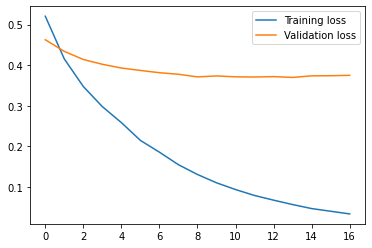

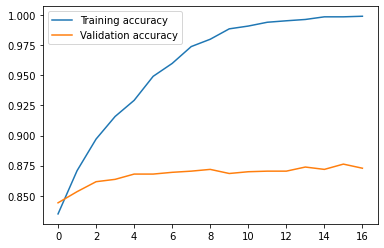

In [15]:
mostrarEvolucion(history)

In [16]:
predecir_guardar_test(model_trained,'fine_tunin_resnet3.csv',test)